<a href="https://www.kaggle.com/code/cristobalchavez/xgboost-drop-columns-and-tuning-with-optuna?scriptVersionId=125561963" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error,  make_scorer, roc_auc_score
prepath = "/home/cristobal"
trainpath = prepath+"/kaggle/input/playground-series-s3e11/train.csv"
testpath = prepath+"/kaggle/input/playground-series-s3e11/test.csv"
originalpath = prepath+"/kaggle/input/media-campaign-cost-prediction/train_dataset.csv"
outputpath = prepath+"/kaggle/working/playground-series-s3e11/"

In [2]:
data = pd.read_csv(trainpath)
data = data.drop(columns=["id"])
data.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


<Axes: >

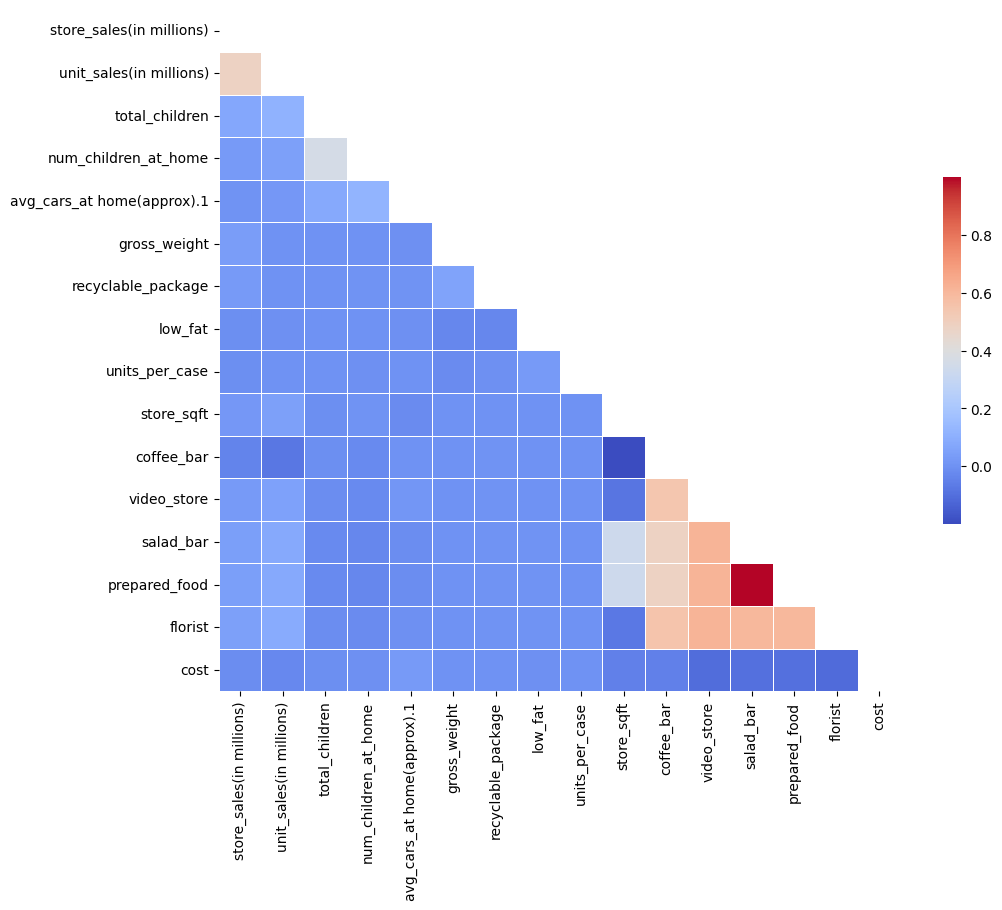

In [3]:
features_target = data.columns
features = list(features_target[:-1])

corr = data[features_target].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, cmap="coolwarm", 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
#Data from original dataset
original_df = pd.read_csv(originalpath)
# original_df.head()

In [5]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(
    data[features], data["cost"], test_size=0.30, random_state=21)
# Add original dataset to training set
train = pd.concat([x_train, y_train], axis=1)
train2 = pd.concat([train, original_df])
# Shuffle
train2 = train2.sample(frac=1)
x_train_2 = train2[features]
y_train_2 = train2["cost"]

In [6]:
# XGBoost default parameters
reg_default = xgb.XGBRegressor(n_estimators=1000,
                            early_stopping_rounds=20, 
                            eval_metric="rmsle",
                            verbosity=0
                         )
reg_default.fit(x_train, y_train, eval_set=[(x_test, y_test)])
print(reg_default)

[0]	validation_0-rmsle:1.16596

[1]	validation_0-rmsle:0.68606

[2]	validation_0-rmsle:0.47733

[3]	validation_0-rmsle:0.37829

[4]	validation_0-rmsle:0.33284

[5]	validation_0-rmsle:0.31316

[6]	validation_0-rmsle:0.30571

[7]	validation_0-rmsle:0.30298

[8]	validation_0-rmsle:0.30229

[9]	validation_0-rmsle:0.30250

[10]	validation_0-rmsle:0.30292

[11]	validation_0-rmsle:0.30348

[12]	validation_0-rmsle:0.30374

[13]	validation_0-rmsle:0.30386

[14]	validation_0-rmsle:0.30391

[15]	validation_0-rmsle:0.30400

[16]	validation_0-rmsle:0.30402

[17]	validation_0-rmsle:0.30402

[18]	validation_0-rmsle:0.30399

[19]	validation_0-rmsle:0.30391

[20]	validation_0-rmsle:0.30395

[21]	validation_0-rmsle:0.30398

[22]	validation_0-rmsle:0.30374

[23]	validation_0-rmsle:0.30360

[24]	validation_0-rmsle:0.30358

[25]	validation_0-rmsle:0.30359

[26]	validation_0-rmsle:0.30360

[27]	validation_0-rmsle:0.30356

XGBRegressor(base_score=None, booster=None, callbacks=None,

             colsample_by

0.30228760775251456


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

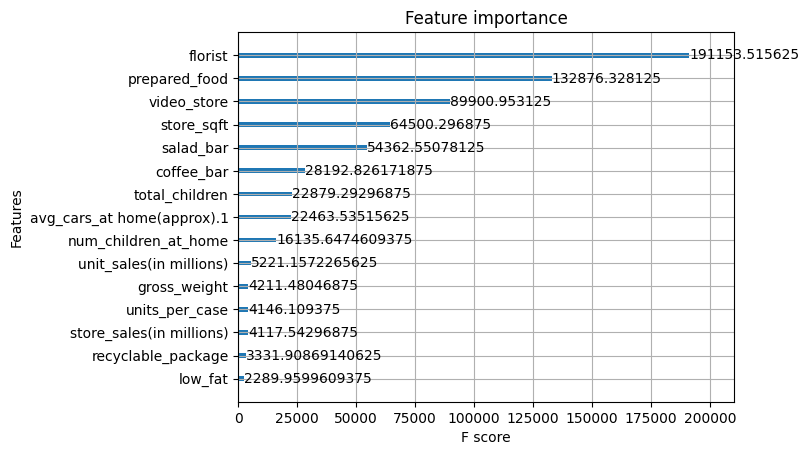

In [7]:
y_pred_test_default = reg_default.predict(x_test).flatten()
#logloss of the model trained with original data
print(mean_squared_log_error(y_test, y_pred_test_default, squared=False)
)
# xgb.plot_importance(reg_default, importance_type='weight')
xgb.plot_importance(reg_default, importance_type='gain')
# xgb.plot_importance(reg_default, importance_type='cover')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

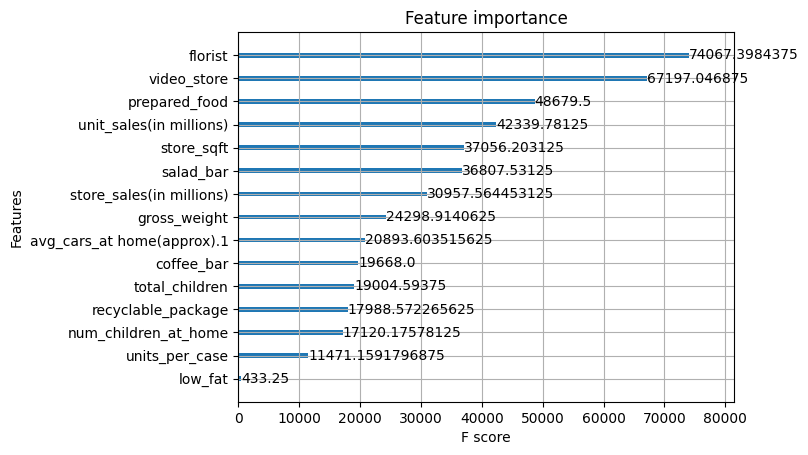

In [8]:
xgb.plot_importance(reg_default, importance_type='cover')

In [9]:
# Best parameters from previous notebook
params = { "n_estimators": 10000,
            "max_depth": 11,
            "learning_rate": 0.01,
            "gamma": 22,
            "min_child_weight": 20,
            "reg_lambda": 0,
            "eval_metric": "rmsle",
            "early_stopping_rounds": 20,
            "objective":"reg:squarederror",
            "verbosity": 1,
            "subsample": 0.8
            }

reg_prev = xgb.XGBRegressor(**params)
reg_prev.fit(x_train, y_train, eval_set=[(x_test, y_test)])
print(reg_prev)

[0]	validation_0-rmsle:3.66466

[1]	validation_0-rmsle:3.33437

[2]	validation_0-rmsle:3.08926

[3]	validation_0-rmsle:2.89470

[4]	validation_0-rmsle:2.73364

[5]	validation_0-rmsle:2.59656

[6]	validation_0-rmsle:2.47733

[7]	validation_0-rmsle:2.37187

[8]	validation_0-rmsle:2.27761

[9]	validation_0-rmsle:2.19241

[10]	validation_0-rmsle:2.11474

[11]	validation_0-rmsle:2.04343

[12]	validation_0-rmsle:1.97768

[13]	validation_0-rmsle:1.91657

[14]	validation_0-rmsle:1.85968

[15]	validation_0-rmsle:1.80649

[16]	validation_0-rmsle:1.75656

[17]	validation_0-rmsle:1.70952

[18]	validation_0-rmsle:1.66509

[19]	validation_0-rmsle:1.62306

[20]	validation_0-rmsle:1.58317

[21]	validation_0-rmsle:1.54522

[22]	validation_0-rmsle:1.50905

[23]	validation_0-rmsle:1.47459

[24]	validation_0-rmsle:1.44163

[25]	validation_0-rmsle:1.41012

[26]	validation_0-rmsle:1.37990

[27]	validation_0-rmsle:1.35092

[28]	validation_0-rmsle:1.32310

[29]	validation_0-rmsle:1.29632

[30]	validation_0-rm

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

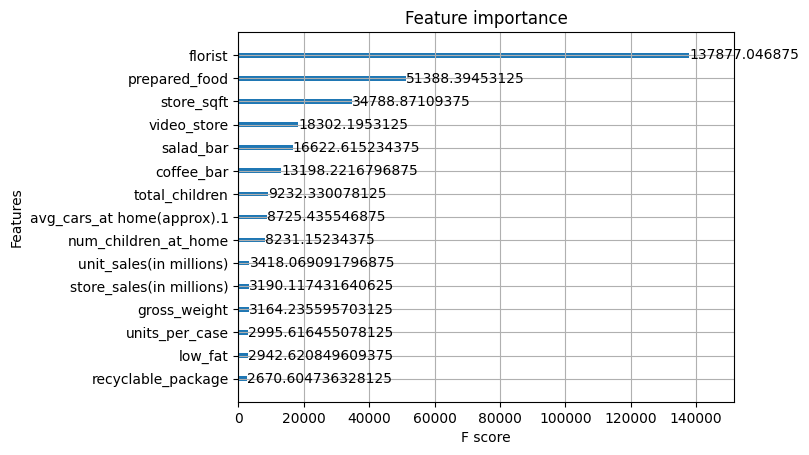

In [10]:
y_pred_test_prev = reg_prev.predict(x_test).flatten()
#logloss of the model trained with original data
mean_squared_log_error(y_test, y_pred_test_prev, squared=False)
# xgb.plot_importance(reg_prev, importance_type='weight')
xgb.plot_importance(reg_prev, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

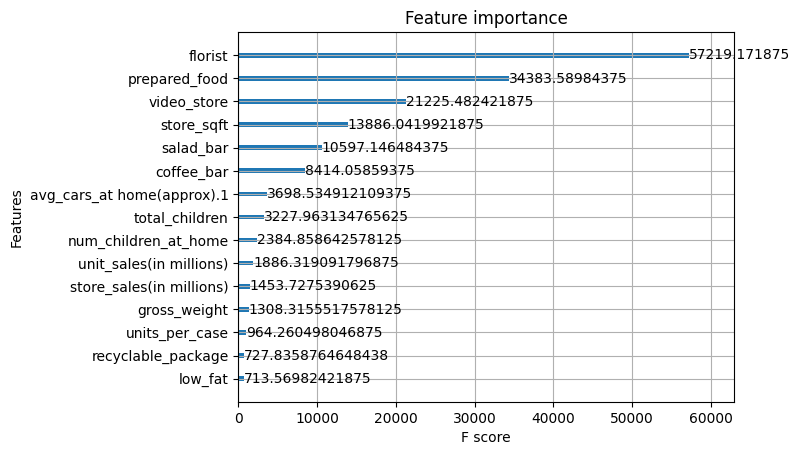

In [11]:
xgb.plot_importance(reg_prev, importance_type='cover')

In [12]:
# Drop features with low average gain
dropping = [
            "low_fat",
            "recyclable_package",
            "units_per_case",
            "gross_weight",
            "store_sales(in millions)",
            "unit_sales(in millions)"
]
x_train_dropped = x_train.drop(columns=dropping, inplace=False)
x_test_dropped = x_test.drop(columns=dropping, inplace=False)
x_train_2_dropped = x_train_2.drop(columns=dropping, inplace=False)

In [13]:
# Find good parameters with optuna and original+generated data
import optuna
from sklearn.model_selection import cross_val_score
rmsle=make_scorer(mean_squared_log_error, greater_is_better=False, squared=False)
def objective(trial):

    param = {
        "objective": 'reg:squarederror',
        "eval_metric": "rmsle",
        'tree_method': 'gpu_hist',
        "n_estimators": 1000,
        "early_stopping_rounds":10,
        "verbosity": 0,
        "reg_lambda": trial.suggest_float("lambda", 1e-5, 100),
        "reg_alpha": trial.suggest_loguniform("alpha", 1e-5, 100),
        "max_depth":  trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.5),
        "gamma": trial.suggest_float("gamma", 0, 30),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 150),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0)
    }

    fit_params = {
                "eval_set":[(x_test_dropped, y_test)],
                "verbose": False
                }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, x_train_2_dropped, y_train_2, scoring=rmsle, cv=5, fit_params=fit_params)

    return scores.mean()
study = optuna.create_study(direction="maximize", study_name="original_data_dropped_columns_1")
study.optimize(objective, n_trials = 300)


/home/cristobal/kaggle/.kaggle_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  from .autonotebook import tqdm as notebook_tqdm

[I 2023-04-03 16:44:33,356] A new study created in memory with name: original_data_dropped_columns_1

/tmp/ipykernel_559/660534030.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

  "reg_alpha": trial.suggest_loguniform("alpha", 1e-5, 100),

[I 2023-04-03 16:44:40,349] Trial 0 finished with value: -0.2976834066676551 and parameters: {'lambda': 90.4310169326509, 'alpha': 0.1418396028694976, 'max_depth': 16, 'learning_rate': 0.4809562480962452, 'gamma': 10.251471819711437, 'min_child_weight': 39, 'subsample': 0.9984157184383895, 'colsample_bytree':

In [14]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: -0.29694029854378934



Optimized parameters: {'lambda': 36.6799124555731, 'alpha': 0.2818529414738129, 'max_depth': 20, 'learning_rate': 0.31431410305245533, 'gamma': 1.2586853806027236, 'min_child_weight': 15, 'subsample': 0.9815177675228409, 'colsample_bytree': 0.7805820806523934}




In [16]:
#Training with best parameters and original+generated data
params = {
        "objective": 'reg:squarederror',
        "eval_metric": "rmsle",
        # 'tree_method': 'gpu_hist',
        "n_estimators": 1000,
        "early_stopping_rounds":20,
        }
# Add best parameters to params dictionary
params.update(best_params)
reg = xgb.XGBRegressor(**params)
reg.fit(x_train_2_dropped, y_train_2, eval_set=[(x_test_dropped, y_test)])
print(reg)

[0]	validation_0-rmsle:1.12448

[1]	validation_0-rmsle:0.65476

[2]	validation_0-rmsle:0.45659

[3]	validation_0-rmsle:0.36657

[4]	validation_0-rmsle:0.32553

[5]	validation_0-rmsle:0.30886

[6]	validation_0-rmsle:0.30053

[7]	validation_0-rmsle:0.29843

[8]	validation_0-rmsle:0.29774

[9]	validation_0-rmsle:0.29649

[10]	validation_0-rmsle:0.29684

[11]	validation_0-rmsle:0.29687

[12]	validation_0-rmsle:0.29715

[13]	validation_0-rmsle:0.29744

[14]	validation_0-rmsle:0.29698

[15]	validation_0-rmsle:0.29703

[16]	validation_0-rmsle:0.29712

[17]	validation_0-rmsle:0.29717

[18]	validation_0-rmsle:0.29709

[19]	validation_0-rmsle:0.29707

[20]	validation_0-rmsle:0.29706

[21]	validation_0-rmsle:0.29682

[22]	validation_0-rmsle:0.29680

[23]	validation_0-rmsle:0.29678

[24]	validation_0-rmsle:0.29677

[25]	validation_0-rmsle:0.29673

[26]	validation_0-rmsle:0.29672

[27]	validation_0-rmsle:0.29669

[28]	validation_0-rmsle:0.29658

[29]	validation_0-rmsle:0.29650

XGBRegressor(alpha=0

In [17]:
y_pred_test = reg.predict(x_test_dropped).flatten()
mean_squared_log_error(y_test, y_pred_test, squared=False)

0.2964914597441476

In [25]:
#Training with best parameters but only on generated data
params = {
        "objective": 'reg:squarederror',
        "eval_metric": "rmsle",
        # 'tree_method': 'gpu_hist',
        "n_estimators": 1000,
        "early_stopping_rounds":20,
        }
# Add best parameters to params dictionary
params.update(best_params)
reg2 = xgb.XGBRegressor(**params)
reg2.fit(x_train_dropped, y_train, eval_set=[(x_test_dropped, y_test)])
print(reg2)

[0]	validation_0-rmsle:1.12452

[1]	validation_0-rmsle:0.65423

[2]	validation_0-rmsle:0.45628

[3]	validation_0-rmsle:0.36603

[4]	validation_0-rmsle:0.32704

[5]	validation_0-rmsle:0.30990

[6]	validation_0-rmsle:0.30311

[7]	validation_0-rmsle:0.30026

[8]	validation_0-rmsle:0.29954

[9]	validation_0-rmsle:0.29767

[10]	validation_0-rmsle:0.29767

[11]	validation_0-rmsle:0.29808

[12]	validation_0-rmsle:0.29730

[13]	validation_0-rmsle:0.29739

[14]	validation_0-rmsle:0.29700

[15]	validation_0-rmsle:0.29702

[16]	validation_0-rmsle:0.29705

[17]	validation_0-rmsle:0.29715

[18]	validation_0-rmsle:0.29690

[19]	validation_0-rmsle:0.29692

[20]	validation_0-rmsle:0.29687

[21]	validation_0-rmsle:0.29683

[22]	validation_0-rmsle:0.29670

[23]	validation_0-rmsle:0.29660

[24]	validation_0-rmsle:0.29658

[25]	validation_0-rmsle:0.29653

[26]	validation_0-rmsle:0.29648

[27]	validation_0-rmsle:0.29649

[28]	validation_0-rmsle:0.29648

[29]	validation_0-rmsle:0.29645

[30]	validation_0-rm

In [26]:
y_pred_test_2 = reg2.predict(x_test_dropped).flatten()
mean_squared_log_error(y_test, y_pred_test_2, squared=False)

0.29626571730533147

In [18]:
# Read data for submission
submit_df = pd.read_csv(testpath)
submit_df.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


In [19]:
submit_id = submit_df["id"]
# Predict the cost of the submission data
submit_dropped = submit_df[features].drop(columns=dropping)
y_pred_submit = reg.predict(submit_dropped).flatten()
submit_final = pd.DataFrame({"id": submit_id, "Class": y_pred_submit})
# Save prediction
submit_final.to_csv(outputpath+"submission3.csv", index=False)

In [27]:
y_pred_submit = reg2.predict(submit_dropped).flatten()
submit_final = pd.DataFrame({"id": submit_id, "Class": y_pred_submit})
# Save prediction
submit_final.to_csv(outputpath+"submission4.csv", index=False)

In [28]:
# Find good parameters with optuna using only generated data
import optuna
from sklearn.model_selection import cross_val_score
rmsle=make_scorer(mean_squared_log_error, greater_is_better=False, squared=False)
def objective(trial):

    param = {
        "objective": 'reg:squarederror',
        "eval_metric": "rmsle",
        'tree_method': 'gpu_hist',
        "n_estimators": 1000,
        "early_stopping_rounds":10,
        "verbosity": 0,
        "reg_lambda": trial.suggest_float("lambda", 0, 100),
        "reg_alpha": trial.suggest_float("alpha", 0, 100),
        "max_depth":  trial.suggest_int("max_depth", 8, 25),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.5, log=True),
        "gamma": trial.suggest_float("gamma", 0, 30),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0)
    }

    fit_params = {
                "eval_set":[(x_test_dropped, y_test)],
                "verbose": False
                }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, x_train_dropped, y_train, scoring=rmsle, cv=5, fit_params=fit_params)

    return scores.mean()
study2 = optuna.create_study(direction="maximize", study_name="dropped_columns_2")
study2.optimize(objective, n_trials = 300)


[I 2023-04-03 18:19:50,325] A new study created in memory with name: dropped_columns_2

[I 2023-04-03 18:20:21,855] Trial 0 finished with value: -0.3032654605620605 and parameters: {'lambda': 31.551175751727413, 'alpha': 90.70200258517755, 'max_depth': 22, 'learning_rate': 0.0029525720631104445, 'gamma': 0.1780189811371824, 'min_child_weight': 28, 'subsample': 0.7089947682956146, 'colsample_bytree': 0.5662641462265233}. Best is trial 0 with value: -0.3032654605620605.

[I 2023-04-03 18:20:30,405] Trial 1 finished with value: -0.30377366082616264 and parameters: {'lambda': 77.43714211884217, 'alpha': 99.95479162822491, 'max_depth': 12, 'learning_rate': 0.014179020276139365, 'gamma': 14.829270628627727, 'min_child_weight': 58, 'subsample': 0.6649437587955458, 'colsample_bytree': 0.5805378052868702}. Best is trial 0 with value: -0.3032654605620605.

[I 2023-04-03 18:20:36,220] Trial 2 finished with value: -0.3066015911685008 and parameters: {'lambda': 82.05567513527262, 'alpha': 63.691507

In [29]:
best_params = study2.best_params
best_score = study2.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: -0.2938664324432391



Optimized parameters: {'lambda': 0.018953620845944846, 'alpha': 5.163246686737796, 'max_depth': 18, 'learning_rate': 0.030517797530984887, 'gamma': 11.661946549041609, 'min_child_weight': 3, 'subsample': 0.6942187516713563, 'colsample_bytree': 0.9230721236192261}




In [30]:
#Training with best parameters and generated data
params = {
        "objective": 'reg:squarederror',
        "eval_metric": "rmsle",
        # 'tree_method': 'gpu_hist',
        "n_estimators": 1000,
        "early_stopping_rounds":20,
        }
# Add best parameters to params dictionary
params.update(best_params)
reg3 = xgb.XGBRegressor(**params)
reg3.fit(x_train_dropped, y_train, eval_set=[(x_test_dropped, y_test)])
print(reg3)

[0]	validation_0-rmsle:3.07115

[1]	validation_0-rmsle:2.57443

[2]	validation_0-rmsle:2.25439

[3]	validation_0-rmsle:2.01993

[4]	validation_0-rmsle:1.83580

[5]	validation_0-rmsle:1.68575

[6]	validation_0-rmsle:1.55960

[7]	validation_0-rmsle:1.45131

[8]	validation_0-rmsle:1.35701

[9]	validation_0-rmsle:1.27381

[10]	validation_0-rmsle:1.19966

[11]	validation_0-rmsle:1.13285

[12]	validation_0-rmsle:1.07271

[13]	validation_0-rmsle:1.01792

[14]	validation_0-rmsle:0.96787

[15]	validation_0-rmsle:0.92194

[16]	validation_0-rmsle:0.87978

[17]	validation_0-rmsle:0.84064

[18]	validation_0-rmsle:0.80456

[19]	validation_0-rmsle:0.77098

[20]	validation_0-rmsle:0.73983

[21]	validation_0-rmsle:0.71088

[22]	validation_0-rmsle:0.68384

[23]	validation_0-rmsle:0.65863

[24]	validation_0-rmsle:0.63507

[25]	validation_0-rmsle:0.61300

[26]	validation_0-rmsle:0.59236

[27]	validation_0-rmsle:0.57295

[28]	validation_0-rmsle:0.55482

[29]	validation_0-rmsle:0.53780

[30]	validation_0-rm

In [31]:
y_pred_test_3 = reg3.predict(x_test_dropped).flatten()
mean_squared_log_error(y_test, y_pred_test_3, squared=False)

0.29354226806570116

In [32]:
y_pred_submit = reg3.predict(submit_dropped).flatten()
submit_final = pd.DataFrame({"id": submit_id, "Class": y_pred_submit})
# Save prediction
submit_final.to_csv(outputpath+"submission5.csv", index=False)

In [33]:
#Training with best parameters and original+generated data
params = {
        "objective": 'reg:squarederror',
        "eval_metric": "rmsle",
        # 'tree_method': 'gpu_hist',
        "n_estimators": 1000,
        "early_stopping_rounds":20,
        }
# Add best parameters to params dictionary
params.update(best_params)
reg4 = xgb.XGBRegressor(**params)
reg4.fit(x_train_2_dropped, y_train_2, eval_set=[(x_test_dropped, y_test)])
print(reg4)

[0]	validation_0-rmsle:3.07128

[1]	validation_0-rmsle:2.57501

[2]	validation_0-rmsle:2.25470

[3]	validation_0-rmsle:2.01956

[4]	validation_0-rmsle:1.83597

[5]	validation_0-rmsle:1.68566

[6]	validation_0-rmsle:1.55951

[7]	validation_0-rmsle:1.45134

[8]	validation_0-rmsle:1.35687

[9]	validation_0-rmsle:1.27363

[10]	validation_0-rmsle:1.19950

[11]	validation_0-rmsle:1.13280

[12]	validation_0-rmsle:1.07242

[13]	validation_0-rmsle:1.01757

[14]	validation_0-rmsle:0.96753

[15]	validation_0-rmsle:0.92157

[16]	validation_0-rmsle:0.87928

[17]	validation_0-rmsle:0.84015

[18]	validation_0-rmsle:0.80407

[19]	validation_0-rmsle:0.77059

[20]	validation_0-rmsle:0.73947

[21]	validation_0-rmsle:0.71050

[22]	validation_0-rmsle:0.68344

[23]	validation_0-rmsle:0.65816

[24]	validation_0-rmsle:0.63457

[25]	validation_0-rmsle:0.61243

[26]	validation_0-rmsle:0.59180

[27]	validation_0-rmsle:0.57241

[28]	validation_0-rmsle:0.55430

[29]	validation_0-rmsle:0.53729

[30]	validation_0-rm

In [34]:
y_pred_test_4 = reg4.predict(x_test_dropped).flatten()
mean_squared_log_error(y_test, y_pred_test_4, squared=False)

0.2935585852324196

In [35]:
y_pred_submit = reg4.predict(submit_dropped).flatten()
submit_final = pd.DataFrame({"id": submit_id, "Class": y_pred_submit})
# Save prediction
submit_final.to_csv(outputpath+"submission6.csv", index=False)